In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
movies = pd.read_csv("ml-20m/movies.csv")

In [7]:
ratings = pd.read_csv("ml-20m/ratings.csv", usecols=['movieId', 'rating'])

In [8]:
genome_scores = pd.read_csv("ml-20m/genome-scores.csv")

In [9]:
genome_tags = pd.read_csv("ml-20m/genome-tags.csv")

In [10]:
imdb_links = pd.read_csv("ml-20m/links.csv")

In [11]:
youtube_links = pd.read_csv("ml-20m/ml-youtube.csv")

In [12]:
links = pd.merge(imdb_links, youtube_links, on='movieId', how='left')[['movieId', 'imdbId', 'youtubeId']]

In [13]:
links.head()

,movieId,imdbId,youtubeId
0,1,114709,K26_sDKnvMU
1,2,113497,3LPANjHlPxo
2,3,113228,rEnOoWs3FuA
3,4,114885,j9xml1CxgXI
4,5,113041,ltwvKLnj1B4


In [14]:
movie_tags = pd.merge(genome_scores, genome_tags, on='tagId')[['movieId', 'tag', 'relevance']]

In [15]:
movie_tags.head()

,movieId,tag,relevance
0,1,007,0.02500
1,2,007,0.03975
2,3,007,0.04350
3,4,007,0.03725
4,5,007,0.04200


In [16]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [17]:
table = genome_scores[:].pivot_table('relevance', index='movieId', columns='tagId', aggfunc='mean')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016EBAA4BB38>]],
      dtype=object)

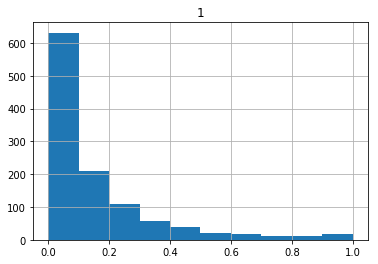

In [18]:
table[:1].T.hist()

In [19]:
movie_tags = genome_scores[genome_scores.relevance > 0.3][['movieId', 'tagId']]

In [20]:
movie_tags = pd.merge(movie_tags, genome_tags, on='tagId', how='left')[['movieId', 'tagId']]

In [21]:
movie_tags.head(5)

,movieId,tagId
0,1,11
1,1,19
2,1,21
3,1,29
4,1,30


In [22]:
movie_tags['tagId'] = movie_tags.tagId.astype(str)

In [23]:
def concatenate_tags(tags):
    tags_as_str = ' '.join(set(tags))
    return tags_as_str

In [24]:
tags_per_movie = movie_tags.groupby('movieId')['tagId'].agg({
    'movie_tags': concatenate_tags
}).reset_index()

C:\Users\arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [25]:
tags_per_movie.head()

,movieId,movie_tags
0,1,1108 990 675 412 93 309 806 21 951 203 752 971...
1,2,1028 21 951 203 752 396 662 717 132 920 377 97...
2,3,654 412 490 850 919 299 277 374 1102 272 203 4...
3,4,1035 585 412 28 490 107 299 497 277 21 374 613...
4,5,1102 203 138 396 920 971 132 1071 377 901 900 ...


In [26]:
avg_ratings = ratings.groupby('movieId')['rating'].agg({
    'rating_mean': 'mean',
    'rating_median': 'median',
    'num_ratings': 'size'
}).reset_index()

C:\Users\arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [27]:
avg_ratings.head()

,movieId,rating_mean,rating_median,num_ratings
0,1,3.921240,4.0,49695
1,2,3.211977,3.0,22243
2,3,3.151040,3.0,12735
3,4,2.861393,3.0,2756
4,5,3.064592,3.0,12161


In [28]:
dataset = pd.merge(movies, avg_ratings, on='movieId', how='left')

In [29]:
dataset = pd.merge(dataset, tags_per_movie, on='movieId', how='left')

In [30]:
dataset.head()

,movieId,title,genres,rating_mean,rating_median,num_ratings,movie_tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.921240,4.0,49695.0,1108 990 675 412 93 309 806 21 951 203 752 971...
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.211977,3.0,22243.0,1028 21 951 203 752 396 662 717 132 920 377 97...
2,3,Grumpier Old Men (1995),Comedy|Romance,3.151040,3.0,12735.0,654 412 490 850 919 299 277 374 1102 272 203 4...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.861393,3.0,2756.0,1035 585 412 28 490 107 299 497 277 21 374 613...
4,5,Father of the Bride Part II (1995),Comedy,3.064592,3.0,12161.0,1102 203 138 396 920 971 132 1071 377 901 900 ...


In [31]:
dataset[dataset.movie_tags.isnull()].head()

,movieId,title,genres,rating_mean,rating_median,num_ratings,movie_tags
50,51,Guardian Angel (1994),Action|Drama|Thriller,2.555556,3.00,27.0,NaN
107,109,Headless Body in Topless Bar (1995),Comedy|Drama|Thriller,2.062500,1.75,16.0,NaN
113,115,Happiness Is in the Field (Bonheur est dans le...,Comedy,3.407895,4.00,38.0,NaN
122,124,"Star Maker, The (Uomo delle stelle, L') (1995)",Drama,3.498433,4.00,319.0,NaN
125,127,"Silences of the Palace, The (Saimt el Qusur) (...",Drama,3.256098,3.00,41.0,NaN


In [32]:
dataset[dataset.rating_mean.isnull()].head()

,movieId,title,genres,rating_mean,rating_median,num_ratings,movie_tags
8555,26018,Chase a Crooked Shadow (1958),Crime|Film-Noir|Mystery|Thriller,NaN,NaN,NaN,NaN
8933,26580,"Park Is Mine, The (1986)",Action|Drama|Thriller,NaN,NaN,NaN,NaN
9249,27249,"Trumpet of the Swan, The (2001)",Animation|Drama|Musical,NaN,NaN,NaN,NaN
9315,27396,"Gentleman's Game, A (2002)",Drama,NaN,NaN,NaN,NaN
9770,31797,White Banners (1938),Drama,NaN,NaN,NaN,NaN


In [33]:
dataset_with_tags = dataset[~dataset.movie_tags.isnull()].reset_index(drop=True)

# Count Vectorizer

In [34]:
c_vectorizer = CountVectorizer()

In [35]:
c_vectorized = c_vectorizer.fit_transform(dataset_with_tags.movie_tags)

In [36]:
c_vectorized_m2m = pd.DataFrame(cosine_similarity(c_vectorized))

In [37]:
c_vectorized_m2m.head(10)

,0,1,2,3,4,5,6,7,8,9,...,10371,10372,10373,10374,10375,10376,10377,10378,10379,10380
0,1.000000,0.524981,0.346501,0.277201,0.361600,0.440813,0.372558,0.379545,0.211700,0.383426,...,0.422813,0.370205,0.228502,0.328025,0.518853,0.138795,0.278589,0.276940,0.332991,0.381005
1,0.524981,1.000000,0.301726,0.264010,0.395118,0.251902,0.315404,0.456612,0.353730,0.457693,...,0.393106,0.397793,0.300919,0.387492,0.473573,0.264381,0.250233,0.226892,0.158573,0.354357
2,0.346501,0.301726,1.000000,0.421053,0.566282,0.253879,0.534456,0.407096,0.236940,0.380504,...,0.401394,0.285967,0.269953,0.297406,0.430997,0.172172,0.240824,0.364117,0.263435,0.304307
3,0.277201,0.264010,0.421053,1.000000,0.402358,0.224585,0.518737,0.424795,0.217195,0.244609,...,0.401394,0.319610,0.269953,0.270369,0.387897,0.196768,0.276948,0.253299,0.284510,0.275778
4,0.361600,0.395118,0.566282,0.402358,1.000000,0.157591,0.574150,0.345796,0.251577,0.311665,...,0.477334,0.414370,0.229304,0.287072,0.463725,0.125354,0.225018,0.282395,0.214817,0.306951
5,0.440813,0.251902,0.253879,0.224585,0.157591,1.000000,0.218727,0.236433,0.263752,0.355490,...,0.215961,0.234064,0.208681,0.346109,0.223893,0.219034,0.361903,0.229095,0.451599,0.370500
6,0.372558,0.315404,0.534456,0.518737,0.574150,0.218727,1.000000,0.348899,0.194606,0.292227,...,0.455556,0.301443,0.228440,0.218026,0.411919,0.176304,0.334457,0.212771,0.283246,0.306741
7,0.379545,0.456612,0.407096,0.424795,0.345796,0.236433,0.348899,1.000000,0.338648,0.383886,...,0.323970,0.322451,0.317744,0.395520,0.449323,0.322590,0.242965,0.271523,0.223253,0.287824
8,0.211700,0.353730,0.236940,0.217195,0.251577,0.263752,0.194606,0.338648,1.000000,0.443537,...,0.225877,0.265049,0.253185,0.410792,0.242536,0.442909,0.149071,0.160357,0.130454,0.181946
9,0.383426,0.457693,0.380504,0.244609,0.311665,0.355490,0.292227,0.383886,0.443537,1.000000,...,0.279827,0.299689,0.290423,0.450268,0.311592,0.285779,0.233177,0.245256,0.228543,0.309376


In [38]:
c_vectorized_m2m_similarity = c_vectorized_m2m.stack().reset_index()

In [39]:
c_vectorized_m2m_similarity.columns = ['first_movie', 'second_movie', 'similarity_score']

In [40]:
c_vectorized_m2m_similarity.head(10)

,first_movie,second_movie,similarity_score
0,0,0,1.000000
1,0,1,0.524981
2,0,2,0.346501
3,0,3,0.277201
4,0,4,0.361600
5,0,5,0.440813
6,0,6,0.372558
7,0,7,0.379545
8,0,8,0.211700
9,0,9,0.383426


# TfIdf Vectorization

In [41]:
tfidf = TfidfVectorizer()

In [42]:
tfidf_vectorized = tfidf.fit_transform(dataset_with_tags.movie_tags)

In [43]:
tfidf_m2m = pd.DataFrame(cosine_similarity(tfidf_vectorized))

In [44]:
tfidf_m2m.head(10)

,0,1,2,3,4,5,6,7,8,9,...,10371,10372,10373,10374,10375,10376,10377,10378,10379,10380
0,1.000000,0.408613,0.171842,0.141888,0.208914,0.244326,0.235981,0.257648,0.084780,0.252850,...,0.294736,0.233159,0.117382,0.173560,0.425415,0.058436,0.133622,0.138510,0.160460,0.221307
1,0.408613,1.000000,0.114144,0.109254,0.211285,0.114038,0.151752,0.282273,0.189460,0.243929,...,0.257415,0.188582,0.142794,0.213585,0.260667,0.125768,0.127490,0.077935,0.052138,0.203258
2,0.171842,0.114144,1.000000,0.253147,0.415846,0.112252,0.379635,0.194865,0.063392,0.179836,...,0.223727,0.103251,0.155037,0.116895,0.196410,0.060445,0.101306,0.210882,0.115281,0.158815
3,0.141888,0.109254,0.253147,1.000000,0.260538,0.081417,0.391780,0.248800,0.061966,0.075990,...,0.226544,0.148416,0.118956,0.110497,0.184142,0.066132,0.133652,0.084864,0.180241,0.123381
4,0.208914,0.211285,0.415846,0.260538,1.000000,0.047524,0.446837,0.179263,0.105187,0.133696,...,0.333483,0.220159,0.132119,0.116496,0.239599,0.030563,0.100656,0.144673,0.110727,0.190319
5,0.244326,0.114038,0.112252,0.081417,0.047524,1.000000,0.076707,0.113191,0.161315,0.196590,...,0.081965,0.103276,0.091660,0.181836,0.075000,0.159571,0.202270,0.094987,0.271041,0.214097
6,0.235981,0.151752,0.379635,0.391780,0.446837,0.076707,1.000000,0.167546,0.040572,0.145440,...,0.324273,0.115649,0.118707,0.069516,0.207384,0.082705,0.172164,0.071039,0.159733,0.164682
7,0.257648,0.282273,0.194865,0.248800,0.179263,0.113191,0.167546,1.000000,0.155762,0.185715,...,0.168687,0.139472,0.154252,0.221279,0.238349,0.147557,0.108810,0.114180,0.087829,0.126243
8,0.084780,0.189460,0.063392,0.061966,0.105187,0.161315,0.040572,0.155762,1.000000,0.272016,...,0.105504,0.104158,0.092477,0.285802,0.069789,0.322846,0.032991,0.051514,0.033190,0.080067
9,0.252850,0.243929,0.179836,0.075990,0.133696,0.196590,0.145440,0.185715,0.272016,1.000000,...,0.117386,0.115543,0.158341,0.262562,0.119891,0.169540,0.086068,0.098377,0.085212,0.149921


In [45]:
tfidf_m2m.ix[1].sort_values(ascending=False)[:20]

C:\Users\arjun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


1       1.000000
1790    0.519667
3183    0.496549
2138    0.491580
7811    0.467281
9683    0.450178
7600    0.442935
9011    0.437014
7619    0.433510
2064    0.430589
9754    0.429825
1657    0.429338
43      0.415344
4602    0.414832
520     0.413229
9055    0.409474
0       0.408613
2306    0.405633
8442    0.405312
8316    0.401081
Name: 1, dtype: float64

In [46]:
m2m_similarity = tfidf_m2m.stack().reset_index()
m2m_similarity.columns = ['first_movie', 'second_movie', 'similarity_score']

In [47]:
m2m_similarity.head(5)

,first_movie,second_movie,similarity_score
0,0,0,1.000000
1,0,1,0.408613
2,0,2,0.171842
3,0,3,0.141888
4,0,4,0.208914


In [48]:
m2m_similarity.tail(5)

,first_movie,second_movie,similarity_score
107765156,10380,10376,0.056000
107765157,10380,10377,0.238251
107765158,10380,10378,0.155326
107765159,10380,10379,0.173412
107765160,10380,10380,1.000000
